In [259]:
import os
import pandas as pd
import numpy as np
import whisper
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from pydub import AudioSegment
from pydub.silence import split_on_silence
from tqdm import tqdm
import language_tool_python
import textstat
import torch
from transformers import BertTokenizer, BertModel
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import VotingRegressor
from sklearn.svm import SVR
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score, classification_report

In [3]:
dir='C:/shl-intern-hiring-assessment/dataset/'

train_df = pd.read_csv(os.path.join(dir, 'train.csv'))
test_df = pd.read_csv(os.path.join(dir, 'test.csv'))
AUDIO_DIR = os.path.join(dir, 'audios_train')
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 444 entries, 0 to 443
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   filename  444 non-null    object 
 1   label     444 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.1+ KB
None


In [5]:
#  Set actual audio folder path here (update if needed)

AUDIO_FOLDER = "C:/shl-intern-hiring-assessment/dataset/audios_train/"  
train_df["audio_path"] = train_df["filename"].apply(lambda x: os.path.join(AUDIO_FOLDER, x))

missing_files = train_df[~train_df["audio_path"].apply(os.path.exists)]

if not missing_files.empty:
    print(f"🚨 Warning: {len(missing_files)} audio files are missing!")
    print(missing_files.head(5))
else:
    print("✅ All audio files exist.")

✅ All audio files exist.


In [7]:
print(train_df.info())
train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 444 entries, 0 to 443
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   filename    444 non-null    object 
 1   label       444 non-null    float64
 2   audio_path  444 non-null    object 
dtypes: float64(1), object(2)
memory usage: 10.5+ KB
None


,filename,label,audio_path
0,audio_1261.wav,1.0,C:/shl-intern-hiring-assessment/dataset/audios...
1,audio_942.wav,1.5,C:/shl-intern-hiring-assessment/dataset/audios...
2,audio_1110.wav,1.5,C:/shl-intern-hiring-assessment/dataset/audios...
3,audio_1024.wav,1.5,C:/shl-intern-hiring-assessment/dataset/audios...
4,audio_538.wav,2.0,C:/shl-intern-hiring-assessment/dataset/audios...


In [9]:
model = whisper.load_model("base")
result = model.transcribe("C:/shl-intern-hiring-assessment/dataset/audios_train/audio_1261.wav")
print(result["text"])

C:\Users\katak\AppData\Roaming\Python\Python311\site-packages\whisper\transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


 1.5% 1.5% 1.5% 1.5% 1.5% 1.5% 1.5% 1.5% 1.5% 1.5% 1.5% 1.5% 1.5% 1.5% 1.5% 1.5% 1.5% 1.5% My favorite hobby is cultivation of plants such as gardening, offers you a rewending the experience with a gardening. I can gain immense of immense of plants to plant and the flowers and herbs to unwaistables.


In [11]:
# REMOVES LONG SILENCE FROM AUDIO TO PRODUCE A CLEAR VERSION 

def trim_silence(audio_path, silence_thresh=-40, min_silence_len=500, keep_silence=200):
    
    if not os.path.exists(audio_path):
        return None
    try:
        audio = AudioSegment.from_file(audio_path, format="wav")

        chunks = split_on_silence(
            audio,
            min_silence_len=min_silence_len,
            silence_thresh=silence_thresh,
            keep_silence=keep_silence
        )
        if not chunks:
            return audio

        cleaned_audio = AudioSegment.empty()
        for chunk in chunks:
            cleaned_audio += chunk

        return cleaned_audio

    except Exception as e:
        print(f"❌ Error trimming {audio_path}: {e}")
        return None

In [13]:
# CLEANS AND TRANSCRIBES AUDIO, SAVING THE PROCESSED FILE.

def transcribe_cleaned_audio(audio_path, save_folder="cleaned_audio"):
    os.makedirs(save_folder, exist_ok=True)

    cleaned = trim_silence(audio_path)
    if cleaned is None:
        return ""

    temp_path = os.path.join(save_folder, os.path.basename(audio_path))
    cleaned.export(temp_path, format="wav")

    try:
        result = model.transcribe(temp_path)
        transcript = " ".join([seg["text"] for seg in result["segments"]]
)
        return transcript
    except Exception as e:
        print(f"❌ Transcription error: {e}")
        return ""

In [15]:
# TRANSCRIBES AUDIO FROM PRE-CLEANED FILES WITHOUT RE-TRIMMING SILENCE.
# CREATES TRANSCRIPT ATTRIBUTE IN DATAFRAME TRAIN_DF.

def transcribe_from_cleaned_only(cleaned_path):
    try:
        result = model.transcribe(cleaned_path)
        transcript = " ".join([seg["text"] for seg in result["segments"]])
        return transcript
    except Exception as e:
        print(f"❌ Transcription error: {e}")
        return ""


train_df['cleaned_audio_path'] = train_df['audio_path'].apply(lambda x: os.path.join("cleaned_audio", os.path.basename(x))
)

train_df['transcript'] = [
    transcribe_from_cleaned_only(path) for path in tqdm(train_df['cleaned_audio_path'], desc="📜 Transcribing Cleaned Audio")
]

📜 Transcribing Cleaned Audio:   0%|                                                           | 0/444 [00:00<?, ?it/s]C:\Users\katak\AppData\Roaming\Python\Python311\site-packages\whisper\transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
📜 Transcribing Cleaned Audio: 100%|███████████████████████████████████████████████| 444/444 [1:15:57<00:00, 10.27s/it]


In [22]:
train_d.head()

,filename,label,audio_path,cleaned_audio_path,transcript
0,audio_1261.wav,1.0,C:/shl-intern-hiring-assessment/dataset/audios...,cleaned_audio\audio_1261.wav,My favorite hobby is cultivation of plants su...
1,audio_942.wav,1.5,C:/shl-intern-hiring-assessment/dataset/audios...,cleaned_audio\audio_942.wav,The playground looks very clear and neat as t...
2,audio_1110.wav,1.5,C:/shl-intern-hiring-assessment/dataset/audios...,cleaned_audio\audio_1110.wav,My goal is to become an electrical employee a...
3,audio_1024.wav,1.5,C:/shl-intern-hiring-assessment/dataset/audios...,cleaned_audio\audio_1024.wav,"Ṭhbhagva plasis in anapadesh, it is in Chetod..."
4,audio_538.wav,2.0,C:/shl-intern-hiring-assessment/dataset/audios...,cleaned_audio\audio_538.wav,"my favorite places, my experience is very goo..."


In [29]:
train_df.head()

,filename,label,audio_path,cleaned_audio_path,transcript,num_errors,error_density
0,audio_1261.wav,1.0,C:/shl-intern-hiring-assessment/dataset/audios...,cleaned_audio\audio_1261.wav,My favorite hobby is cultivation of plants su...,4.0,0.114286
1,audio_942.wav,1.5,C:/shl-intern-hiring-assessment/dataset/audios...,cleaned_audio\audio_942.wav,The playground looks very clear and neat as t...,3.0,0.073171
2,audio_1110.wav,1.5,C:/shl-intern-hiring-assessment/dataset/audios...,cleaned_audio\audio_1110.wav,My goal is to become an electrical employee a...,2.0,0.040816
3,audio_1024.wav,1.5,C:/shl-intern-hiring-assessment/dataset/audios...,cleaned_audio\audio_1024.wav,"Ṭhbhagva plasis in anapadesh, it is in Chetod...",11.0,0.177419
4,audio_538.wav,2.0,C:/shl-intern-hiring-assessment/dataset/audios...,cleaned_audio\audio_538.wav,"my favorite places, my experience is very goo...",13.0,0.119266


In [24]:
tool = language_tool_python.LanguageTool('en-US')

def grammar_features(text):
    try:
        matches = tool.check(text)
        num_errors = len(matches)
        num_words = len(text.split())
        error_density = num_errors / max(1, num_words)
        return pd.Series([num_errors, error_density])
    except:
        return pd.Series([0, 0])


train_df[['num_errors', 'error_density']] = train_df['transcript'].apply(grammar_features) 

In [36]:
# SAVES THE FINAL DATAFRAME WITH TRANSCRIPTS TO A CSV FILE.

train_df.to_csv("final_transcripts.csv", index=False)

In [ ]:
add = 'C:/SHL_Assessment/'
train_d = pd.read_csv(os.path.join(add, 'final_transcripts.csv'))
train_df.head()

In [43]:
# CALCULATES WORD COUNT, CHARACTER COUNT, AND AVERAGE WORD LENGTH FROM TRANSCRIPTS.

train_df['words_count'] = train_df['transcript'].apply(lambda x: len(x.split()))
train_df['char_count'] = train_df['transcript'].apply(len)
train_df["avg_word_len"] = train_df["char_count"] / train_df["words_count"]

In [45]:
#COUNTS NUMBER OF COMPLEX WORDS IN EACH TRANSCRIPT.

train_df["complex_words"] = train_df["transcript"].apply(lambda x: sum(len(word) > 6 for word in x.split()))

In [47]:
# CALCULATES FLESCH READING EASE SCORE TO ASSESS TRANSCRIPT READABILITITY.

train_df['readability'] = train_df['transcript'].apply(textstat.flesch_reading_ease)

In [149]:
# GENERATED BERT [CLS] EMBEDDINGS FOR EACH TRANSCRIPT TO CAPTURE SEMANTIC MEANING.

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")


def get_cls_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
    return cls_embedding


tqdm.pandas()

train_df['embedding'] = train_df['transcript'].progress_apply(get_cls_embedding)
bert_embeddings = np.vstack(train_df['embedding'].values)


100%|████████████████████████████████████████████████████████████████████████████████| 444/444 [01:07<00:00,  6.54it/s]


In [145]:
train_df.head(2)
train_df.shape

(444, 12)

In [63]:
# PREPROCESSING : COMBINES, SCALES, IMPUTES FEATURES, AND SPLITS DATA FOR TRAINING.

grammar_features = train_df[['num_errors', 'error_density', 'complex_words', 'words_count', 'char_count', 'avg_word_len', 'readability']]

s_imputer = SimpleImputer(strategy='mean')
X_imp = s_imputer.fit_transform(grammar_features)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imp)

scaled_grammar_df = pd.DataFrame(X_scaled, columns=grammar_features.columns, index=train_df.index)
scaled_grammar_df.head()

,num_errors,error_density,complex_words,words_count,char_count,avg_word_len,readability
0,-0.365102,0.031999,-0.616003,-1.148973,-1.272400,-0.029436,-0.064479
1,-0.414919,-0.198620,-0.757569,-1.064368,-1.214052,-0.064006,0.275486
2,-0.464736,-0.380100,-0.332871,-0.951560,-0.999085,-0.013343,-0.860016
3,-0.016381,0.386123,-0.403654,-0.768248,-0.802544,-0.032479,-0.144082
4,0.083253,0.059934,-0.191305,-0.105503,-0.139217,-0.076522,-0.017207


In [67]:
train_df = train_df.drop(['num_errors', 'error_density', 'complex_words', 'words_count', 'char_count', 'avg_word_len', 'readability'], axis=1)
train_df.head()

,filename,label,audio_path,cleaned_audio_path,transcript,embedding
0,audio_1261.wav,1.0,C:/shl-intern-hiring-assessment/dataset/audios...,cleaned_audio\audio_1261.wav,My favorite hobby is cultivation of plants su...,"[-0.000365064, 0.057224132, 0.18798916, -0.338..."
1,audio_942.wav,1.5,C:/shl-intern-hiring-assessment/dataset/audios...,cleaned_audio\audio_942.wav,The playground looks very clear and neat as t...,"[0.08295897, -0.28695342, -0.053830978, 0.1931..."
2,audio_1110.wav,1.5,C:/shl-intern-hiring-assessment/dataset/audios...,cleaned_audio\audio_1110.wav,My goal is to become an electrical employee a...,"[0.047312357, 0.39743635, -0.20463803, -0.2456..."
3,audio_1024.wav,1.5,C:/shl-intern-hiring-assessment/dataset/audios...,cleaned_audio\audio_1024.wav,"Ṭhbhagva plasis in anapadesh, it is in Chetod...","[-0.5731927, -0.2590856, 0.32029852, -0.145636..."
4,audio_538.wav,2.0,C:/shl-intern-hiring-assessment/dataset/audios...,cleaned_audio\audio_538.wav,"my favorite places, my experience is very goo...","[0.40402788, -0.11970158, 0.07150428, -0.29986..."


In [101]:
train_df = pd.concat([train_df, scaled_grammar_df], axis=1)
train_df.head()

,filename,label,audio_path,cleaned_audio_path,transcript,embedding,num_errors,error_density,complex_words,words_count,char_count,avg_word_len,readability,num_errors,error_density,complex_words,words_count,char_count,avg_word_len,readability
0,audio_1261.wav,1.0,C:/shl-intern-hiring-assessment/dataset/audios...,cleaned_audio\audio_1261.wav,My favorite hobby is cultivation of plants su...,"[-0.000365064, 0.057224132, 0.18798916, -0.338...",-0.365102,0.031999,-0.616003,-1.148973,-1.272400,-0.029436,-0.064479,-0.365102,0.031999,-0.616003,-1.148973,-1.272400,-0.029436,-0.064479
1,audio_942.wav,1.5,C:/shl-intern-hiring-assessment/dataset/audios...,cleaned_audio\audio_942.wav,The playground looks very clear and neat as t...,"[0.08295897, -0.28695342, -0.053830978, 0.1931...",-0.414919,-0.198620,-0.757569,-1.064368,-1.214052,-0.064006,0.275486,-0.414919,-0.198620,-0.757569,-1.064368,-1.214052,-0.064006,0.275486
2,audio_1110.wav,1.5,C:/shl-intern-hiring-assessment/dataset/audios...,cleaned_audio\audio_1110.wav,My goal is to become an electrical employee a...,"[0.047312357, 0.39743635, -0.20463803, -0.2456...",-0.464736,-0.380100,-0.332871,-0.951560,-0.999085,-0.013343,-0.860016,-0.464736,-0.380100,-0.332871,-0.951560,-0.999085,-0.013343,-0.860016
3,audio_1024.wav,1.5,C:/shl-intern-hiring-assessment/dataset/audios...,cleaned_audio\audio_1024.wav,"Ṭhbhagva plasis in anapadesh, it is in Chetod...","[-0.5731927, -0.2590856, 0.32029852, -0.145636...",-0.016381,0.386123,-0.403654,-0.768248,-0.802544,-0.032479,-0.144082,-0.016381,0.386123,-0.403654,-0.768248,-0.802544,-0.032479,-0.144082
4,audio_538.wav,2.0,C:/shl-intern-hiring-assessment/dataset/audios...,cleaned_audio\audio_538.wav,"my favorite places, my experience is very goo...","[0.40402788, -0.11970158, 0.07150428, -0.29986...",0.083253,0.059934,-0.191305,-0.105503,-0.139217,-0.076522,-0.017207,0.083253,0.059934,-0.191305,-0.105503,-0.139217,-0.076522,-0.017207


In [159]:
X_combined = np.hstack((bert_embeddings, grammar_features))
imputer = SimpleImputer(strategy='mean')
X_combined_clean = imputer.fit_transform(X_combined)

In [161]:
# SPLIING THE DATAFRAME INTO TRAIN AND TEST FOR EVALUATION OF THE MODEL PERFORMANCE.

X = X_combined_clean
X_train, X_test, y_train, y_test = train_test_split(X, train_df['label'], test_size=0.2, random_state=42)

In [75]:
# CREATED A COPY OF DATAFRAME FOR GRAMMAR FEATURES
grammar_df = train_df[['num_errors', 'error_density', 'words_count', 'char_count', 'avg_word_len', 'complex_words', 'readability']].copy()
grammar_df['label'] = train_df['label']

C:\Users\katak\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\katak\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\katak\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\katak\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

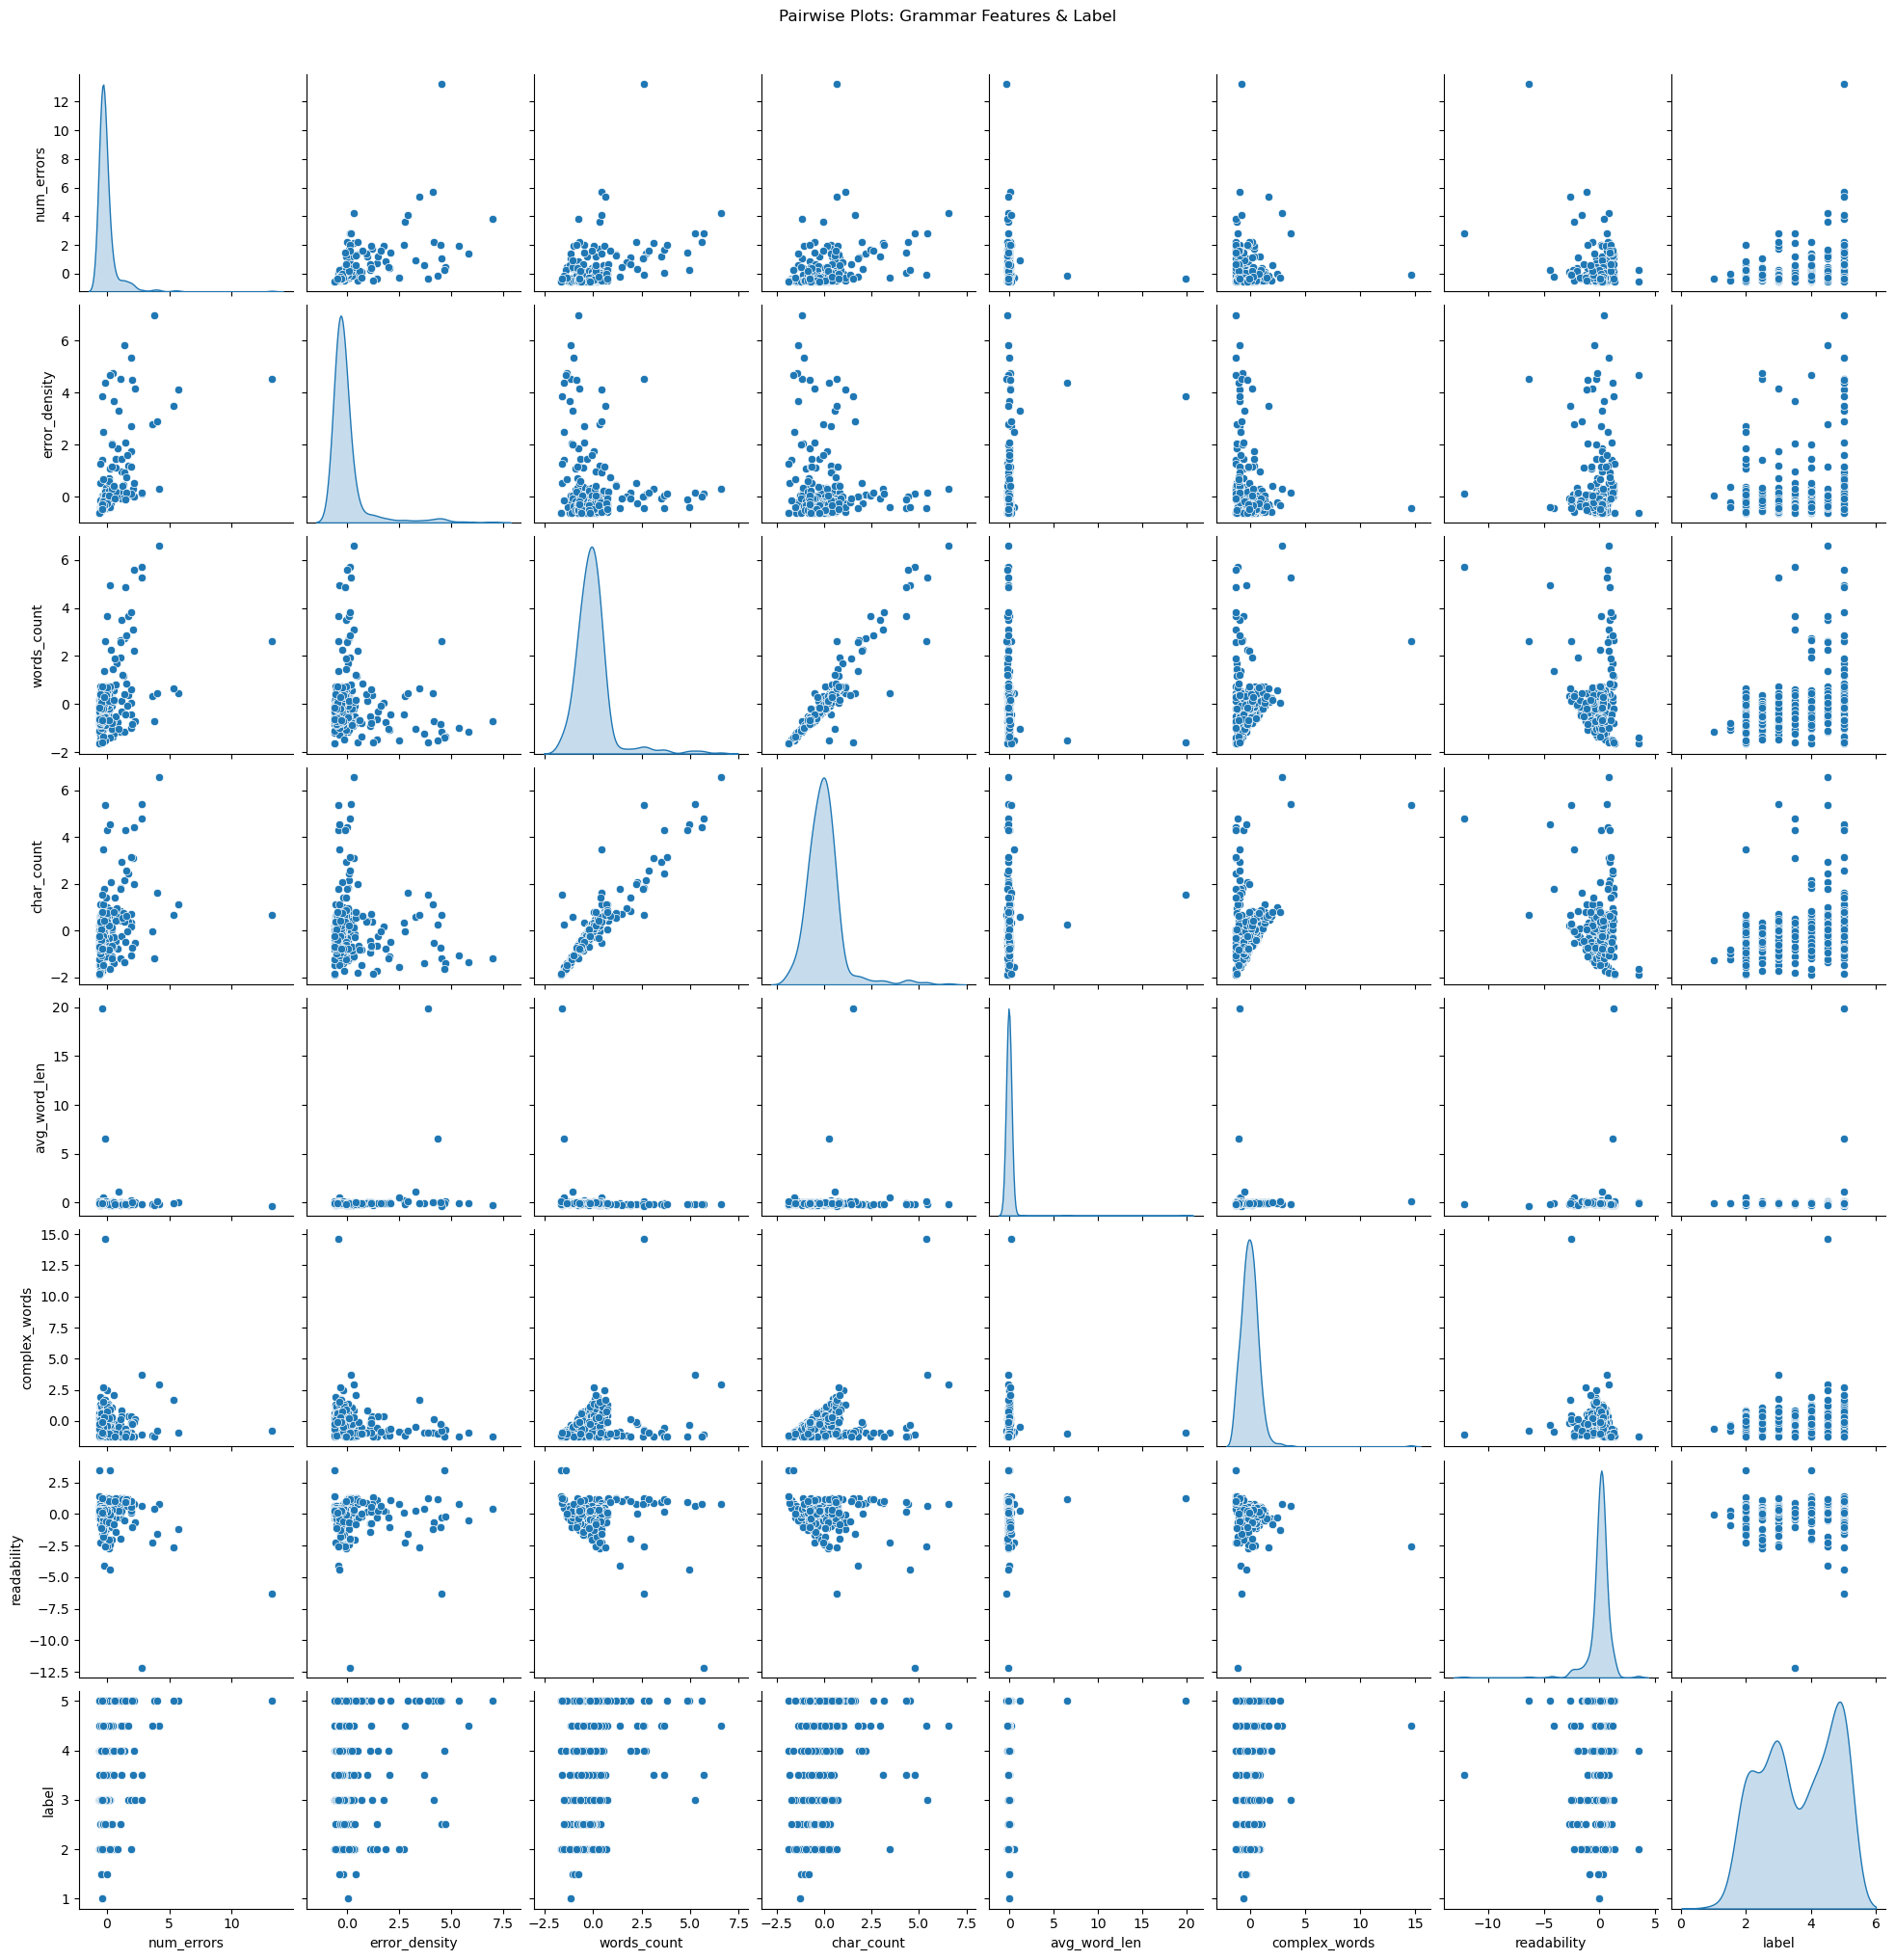

In [83]:
# THIS PAIRPLOT VISUALIZES RELATIONSGIPS BETWEEN EACH PAIR OF GRAMMAR FEATURES AND LABEL.

sns.pairplot(grammar_df, diag_kind='kde')
plt.suptitle("Pairwise Plots: Grammar Features & Label", y=1.02)
plt.show()

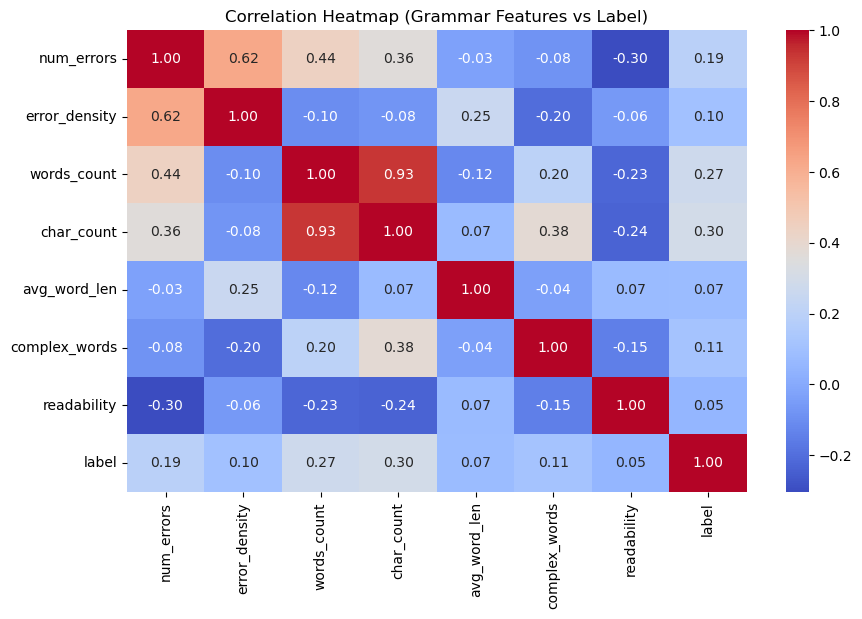

In [165]:
# HEATMAP SHOWS HOW STRONGLY EACH GRAMMAR-BASED FEATURE CORRELATES WITH THE GRAMMER SCORE.
# IT HELPS IDENTIFY WHICH FEATURES ARE MOST RELEVANT FOR PREDICTION.

plt.figure(figsize=(10, 6))
sns.heatmap(grammar_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap (Grammar Features vs Label)")
plt.show()

In [261]:
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import StackingRegressor

base_models = [
    ('catboost', CatBoostRegressor(verbose=0)),
    ('svr', SVR(C=1.0, kernel='rbf'))
]

stacking_model = StackingRegressor(
    estimators=base_models,
    final_estimator=RidgeCV()
)

stacking_model.fit(X_train, y_train)
y_pred = stacking_model.predict(X_test)

print("Stacking MSE:", mean_squared_error(y_test, y_pred))
print("Stacking R² Score:", r2_score(y_test, y_pred))

Stacking MSE: 0.7394577404221285
Stacking R² Score: 0.4575369518977839


In [175]:
# TEST_DF

AUDIO_FOLDER = "C:/shl-intern-hiring-assessment/dataset/audios_test/"
test_df["audio_path"] = test_df["filename"].apply(lambda x: os.path.join(AUDIO_FOLDER, x))

In [179]:
# This recreates and saves cleaned versions
def batch_trim_test_audio(df, input_col="audio_path", output_folder="cleaned_audio"):
    os.makedirs(output_folder, exist_ok=True)
    for path in tqdm(df[input_col], desc="✂️ Trimming Silence (Test Set)"):
        cleaned = trim_silence(path)
        if cleaned:
            cleaned.export(os.path.join(output_folder, os.path.basename(path)), format="wav")

# Call it
batch_trim_test_audio(test_df)

✂️ Trimming Silence (Test Set): 100%|████████████████████████████████████████████████| 195/195 [03:49<00:00,  1.18s/it]


In [195]:
# Load the base model 
model_test = whisper.load_model("base")

In [197]:
def transcribe_from_cleaned_only(cleaned_path):
    try:
        result = model_test.transcribe(cleaned_path)
        return result["text"]
    except Exception as e:
        print(f"Transcription error: {e}")
        return ""

In [199]:
test_df['transcript'] = [
    transcribe_from_cleaned_only(path) for path in tqdm(test_df['cleaned_audio_path'], desc="Transcribing Cleaned Test Audio")
]

📜 Transcribing Cleaned Test Audio:   0%|                                                      | 0/195 [00:00<?, ?it/s]C:\Users\katak\AppData\Roaming\Python\Python311\site-packages\whisper\transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
📜 Transcribing Cleaned Test Audio: 100%|██████████████████████████████████████████| 195/195 [3:03:32<00:00, 56.47s/it]


In [201]:
def grammar_features(text):
    try:
        matches = tool.check(text)
        num_errors = len(matches)
        num_words = len(text.split())
        error_density = num_errors / max(1, num_words)
        return pd.Series([num_errors, error_density])
    except:
        return pd.Series([0, 0])

test_df[['num_errors', 'error_density']] = test_df['transcript'].apply(grammar_features).astype(float)

In [203]:
test_df['words_count'] = test_df['transcript'].apply(lambda x: len(x.split()))
test_df['char_count'] = test_df['transcript'].apply(len)
test_df['avg_word_len'] = test_df['char_count'] / test_df['words_count']
test_df["complex_words"] = test_df["transcript"].apply(lambda x: sum(len(word) > 6 for word in x.split()))
test_df['readability'] = test_df['transcript'].apply(textstat.flesch_reading_ease)

In [205]:
test_df['embedding'] = test_df['transcript'].apply(get_cls_embedding)

In [206]:
test_df.head()

,filename,audio_path,cleaned_audio_path,transcript,num_errors,error_density,words_count,char_count,avg_word_len,complex_words,readability,embedding
0,audio_706.wav,C:/shl-intern-hiring-assessment/dataset/audios...,cleaned_audio\audio_706.wav,۔ ۔ ۔ifully ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔,1.0,0.076923,13,32,2.461538,1,36.62,"[-0.39337865, 0.5389106, -0.46653262, -0.56111..."
1,audio_800.wav,C:/shl-intern-hiring-assessment/dataset/audios...,cleaned_audio\audio_800.wav,My hobbies are playing cricket because I am a...,2.0,0.034483,58,296,5.103448,12,67.42,"[-0.05216193, -0.0108542815, 0.23990324, -0.40..."
2,audio_68.wav,C:/shl-intern-hiring-assessment/dataset/audios...,cleaned_audio\audio_68.wav,"Jason, at this market you can find a lot of t...",4.0,0.030303,132,654,4.954545,16,70.06,"[0.5235996, -0.13337842, -0.018437635, 0.26486..."
3,audio_1267.wav,C:/shl-intern-hiring-assessment/dataset/audios...,cleaned_audio\audio_1267.wav,my goal is I become an interpreter in the bra...,1.0,0.013889,72,387,5.375000,17,65.32,"[0.30160785, 0.31033552, -0.023072887, -0.3962..."
4,audio_683.wav,C:/shl-intern-hiring-assessment/dataset/audios...,cleaned_audio\audio_683.wav,"Okay, in the core market there is a lot of pe...",5.0,0.040984,122,585,4.795082,10,-18.52,"[-0.029568829, -0.12192929, 0.4094353, 0.29053..."


In [257]:
test_grammar = test_df[['num_errors', 'error_density', 'complex_words', 'words_count', 'char_count', 'avg_word_len', 'readability']]

X_test_imputed = s_imputer.fit_transform(test_grammar)

X_test_scaled = scaler.fit_transform(X_test_imputed)

processed_grammer = pd.DataFrame(X_test_scaled, columns=test_grammar.columns, index=test_df.index)

KeyError: "None of [Index(['num_errors', 'error_density', 'complex_words', 'words_count',\n       'char_count', 'avg_word_len', 'readability'],\n      dtype='object')] are in the [columns]"

In [255]:
test_df = test_df.drop(['num_errors', 'error_density', 'complex_words', 'words_count', 'char_count', 'avg_word_len', 'readability'], axis=1)

In [253]:
test_df = pd.concat([test_df, processed_grammer], axis=1)

In [225]:
test_df['embedding'] = test_df['transcript'].progress_apply(get_cls_embedding)
test_embeddings = np.vstack(test_df['embedding'].values)

100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [00:30<00:00,  6.48it/s]


In [231]:
X_test_combined = np.hstack((test_embeddings, processed_grammer.values))
imputer = SimpleImputer(strategy='mean')
X_test_final = imputer.fit_transform(X_test_combined)

In [241]:
predict_model =  stacking_model.predict(X_test_final)

In [251]:
submission = pd.read_csv(os.path.join(dir, "sample_submission.csv"))
submission['label'] = predict_model

submission['label'] = (submission['label']*2).round() /2
submission['label'] = submission['label'].round(1)

submission.to_csv("submission.csv", index=False)
print("Submission file saved!")

Submission file saved!


C:\Users\katak\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


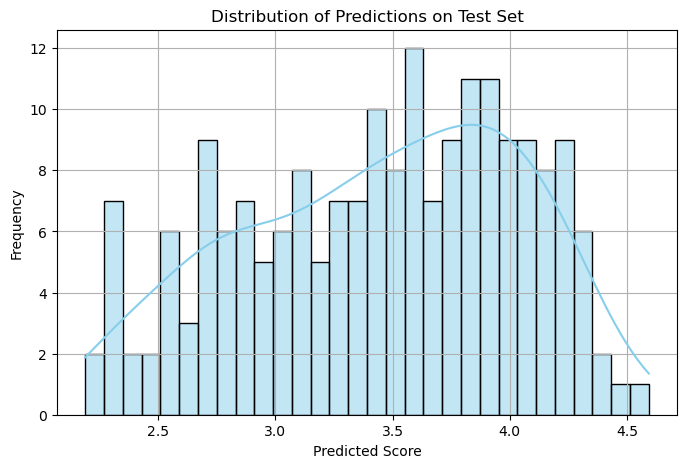

In [237]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.histplot(predict_model, bins=30, kde=True, color='skyblue')
plt.title("Distribution of Predictions on Test Set")
plt.xlabel("Predicted Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()